In [1]:
import json
import os
import re

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
DATA_ROOT = './data'
PGN = os.path.join(DATA_ROOT, 'data.pgn')
STOCKFISH = os.path.join(DATA_ROOT, 'stockfish.csv')

# Get to know the data

### First, let's take a look at the PGN file

In [3]:
with open(PGN) as f:
    for i in range(100):
        print(next(f))

[Event "1"]

[Site "kaggle.com"]

[Date "??"]

[Round "??"]

[White "??"]

[Black "??"]

[Result "1/2-1/2"]

[WhiteElo "2354"]

[BlackElo "2411"]



1. Nf3 Nf6 2. c4 c5 3. b3 g6 4. Bb2 Bg7 5. e3 O-O 6. Be2 b6 7. O-O Bb7 8.

Nc3 Nc6 9. Qc2 Rc8 10. Rac1 d5 11. Nxd5 Nxd5 12. Bxg7 Nf4 13. exf4 Kxg7 14.

Qc3+ Kg8 15. Rcd1 Qd6 16. d4 cxd4 17. Nxd4 Qxf4 18. Bf3 Qf6 19. Nb5 Qxc3

1/2-1/2



[Event "2"]

[Site "kaggle.com"]

[Date "??"]

[Round "??"]

[White "??"]

[Black "??"]

[Result "1/2-1/2"]

[WhiteElo "2523"]

[BlackElo "2460"]



1. e4 e5 2. Nf3 Nf6 3. d4 Nxe4 4. Nxe5 d6 5. Nf3 d5 6. Bd3 Nd6 7. O-O

1/2-1/2



[Event "3"]

[Site "kaggle.com"]

[Date "??"]

[Round "??"]

[White "??"]

[Black "??"]

[Result "0-1"]

[WhiteElo "1915"]

[BlackElo "1999"]



1. e4 d5 2. exd5 Nf6 3. d4 Nxd5 4. Nf3 g6 5. Be2 Bg7 6. c4 Nb6 7. Nc3 O-O

8. O-O Nc6 9. Be3 Bg4 10. d5 Bxf3 11. Bxf3 Ne5 12. Bxb6 Nxf3+ 13. Qxf3 axb6

14. a3 Qd7 15. Rad1 Qf5 16. Qxf5 gxf5 17. Rd3 Rfd8 18. Rfd1 Kf8 19. R1d2

Rd7 20. f4 R

Very well structured text data. We need a function to parse it into a DataFrame for easier processing.

In [4]:
def pgn2dataframe(file_obj):
    """Read a PGN file and return a `pandas.DataFrame` containing all data."""
    
    # Store all match data as a list of dictionary
    json_objs = []
    entry = {}
    # Since move sequences span multiple lines, we should
    # store all lines and join them at appropriate time
    move_seq = []
    # Regex pattern for metadata lines
    pattern = re.compile(r'\[([A-Za-z]+) "(.*)"\]')
    
    # Loop through each line in the file, building the list of match data
    for row in file_obj:
        row_ = row.strip()
        m = pattern.match(row_)
        if m:
            # Metadata line
            entry[m.group(1)] = m.group(2)
        else:
            if not row_:
                # Empty line: skip
                continue
            for result in '0-1', '1-0', '1/2-1/2':
                if row_.endswith(result):
                    # Last row of move sequence.
                    # Remove the result at the end
                    t = row_[:-len(result)].strip()
                    if t:
                        move_seq.append(t)
                    entry['Moves'] = ' '.join(move_seq)
                    # Here we already have a complete record of 1 match
                    # Put the record to our list then reset the temporary
                    # object to record the next match
                    json_objs.append(entry)
                    entry = {}
                    move_seq = []
                    break
            else:
                    # Move sequence line
                    move_seq.append(row_)

    return pd.DataFrame(json_objs)

In [5]:
# Parse pgn data to json
# Might take a few seconds
with open(PGN) as f:
    all_matches = pgn2dataframe(f)

all_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
Black       50000 non-null object
BlackElo    25000 non-null object
Date        50000 non-null object
Event       50000 non-null object
Moves       50000 non-null object
Result      50000 non-null object
Round       50000 non-null object
Site        50000 non-null object
White       50000 non-null object
WhiteElo    25000 non-null object
dtypes: object(10)
memory usage: 3.8+ MB


So far so good.
The only columns with null are `"BlackElo"` and `"WhiteElo"`, which are the ones we have to predict.

In [6]:
all_matches.head()

,Black,BlackElo,Date,Event,Moves,Result,Round,Site,White,WhiteElo
0,??,2411,??,1,1. Nf3 Nf6 2. c4 c5 3. b3 g6 4. Bb2 Bg7 5. e3 ...,1/2-1/2,??,kaggle.com,??,2354
1,??,2460,??,2,1. e4 e5 2. Nf3 Nf6 3. d4 Nxe4 4. Nxe5 d6 5. N...,1/2-1/2,??,kaggle.com,??,2523
2,??,1999,??,3,1. e4 d5 2. exd5 Nf6 3. d4 Nxd5 4. Nf3 g6 5. B...,0-1,??,kaggle.com,??,1915
3,??,2191,??,4,1. c4 Nf6 2. Nc3 d6 3. d4 e5 4. Nf3 Nbd7 5. Bg...,1-0,??,kaggle.com,??,2446
4,??,2075,??,5,1. e4 c5 2. Nf3 d6 3. b4 Nf6 4. bxc5 Nxe4 5. c...,1-0,??,kaggle.com,??,2168


Let's see if we can drop those `"??"` columns

In [7]:
for col in 'Black', 'Date', 'Round', 'Site', 'White':
    print(all_matches[col].value_counts())

??    50000
Name: Black, dtype: int64
??    50000
Name: Date, dtype: int64
??    50000
Name: Round, dtype: int64
kaggle.com    50000
Name: Site, dtype: int64
??    50000
Name: White, dtype: int64


OK, we don't need those columns. 

In [8]:
all_matches.drop(columns=['Black', 'Date', 'Round', 'Site', 'White'], inplace=True)

We can also use the `"Event"` column as index column. Will come in handy later.

In [9]:
all_matches['Event'] = all_matches['Event'].astype(np.int64)
all_matches.set_index('Event', inplace=True)
all_matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 1 to 50000
Data columns (total 4 columns):
BlackElo    25000 non-null object
Moves       50000 non-null object
Result      50000 non-null object
WhiteElo    25000 non-null object
dtypes: object(4)
memory usage: 1.9+ MB


### Now for the Stockfish file

It's already in CSV format. Convenient!

In [10]:
move_scores = pd.read_csv(STOCKFISH)
move_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
Event         50000 non-null int64
MoveScores    50000 non-null object
dtypes: int64(1), object(1)
memory usage: 781.3+ KB


In [11]:
move_scores.head()

,Event,MoveScores
0,1,18 17 12 8 -5 12 3 -2 22 21 20 13 8 21 11 3 -6...
1,2,26 44 26 18 14 34 36 31 37 35 42 52 55
2,3,26 51 68 57 65 77 48 93 61 63 63 58 53 46 69 2...
3,4,2 21 5 53 35 45 37 54 10 22 8 48 30 17 13 35 -...
4,5,26 64 35 53 18 20 18 20 10 49 60 95 91 82 83 9...


We can join the 2 data frames into 1 here.
Note that it won't work if we don't set `"Event"` to be the index column in both data frames.

In [12]:
all_matches = all_matches.join(move_scores.set_index('Event'))
all_matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 1 to 50000
Data columns (total 5 columns):
BlackElo      25000 non-null object
Moves         50000 non-null object
Result        50000 non-null object
WhiteElo      25000 non-null object
MoveScores    50000 non-null object
dtypes: object(5)
memory usage: 3.5+ MB


In [13]:
all_matches.head()

,BlackElo,Moves,Result,WhiteElo,MoveScores
Event,,,,,
1,2411,1. Nf3 Nf6 2. c4 c5 3. b3 g6 4. Bb2 Bg7 5. e3 ...,1/2-1/2,2354,18 17 12 8 -5 12 3 -2 22 21 20 13 8 21 11 3 -6...
2,2460,1. e4 e5 2. Nf3 Nf6 3. d4 Nxe4 4. Nxe5 d6 5. N...,1/2-1/2,2523,26 44 26 18 14 34 36 31 37 35 42 52 55
3,1999,1. e4 d5 2. exd5 Nf6 3. d4 Nxd5 4. Nf3 g6 5. B...,0-1,1915,26 51 68 57 65 77 48 93 61 63 63 58 53 46 69 2...
4,2191,1. c4 Nf6 2. Nc3 d6 3. d4 e5 4. Nf3 Nbd7 5. Bg...,1-0,2446,2 21 5 53 35 45 37 54 10 22 8 48 30 17 13 35 -...
5,2075,1. e4 c5 2. Nf3 d6 3. b4 Nf6 4. bxc5 Nxe4 5. c...,1-0,2168,26 64 35 53 18 20 18 20 10 49 60 95 91 82 83 9...


Now we don't need `move_scores` anymore 

In [14]:
del move_scores

In [15]:
all_matches['WhiteElo'] = pd.to_numeric(all_matches['WhiteElo'])
all_matches['BlackElo'] = pd.to_numeric(all_matches['BlackElo'])

# Feature engineer & Visualization

@todo: I choose not to make use of the `"Moves"` column and remove it completely.
You can try to make use of it, for example by look up the first few moves to know the name of the opening pattern.

In [16]:
all_matches.drop('Moves', axis=1, inplace=True)

Let's make a new column `"WhitePoint"` to replace `"Result"`.
We don't need black point since we know that `black point + white point = 1`.

@todo: It might be better to treat `"Result"` as categorical data as there are only 3 possible values.

In [17]:
all_matches['WhitePoint'] = all_matches['Result'].apply(lambda x: eval(x[:len(x)//2]))
all_matches.drop(columns=['Result'], inplace=True)
all_matches.head()

,BlackElo,WhiteElo,MoveScores,WhitePoint
Event,,,,
1,2411.0,2354.0,18 17 12 8 -5 12 3 -2 22 21 20 13 8 21 11 3 -6...,0.5
2,2460.0,2523.0,26 44 26 18 14 34 36 31 37 35 42 52 55,0.5
3,1999.0,1915.0,26 51 68 57 65 77 48 93 61 63 63 58 53 46 69 2...,0.0
4,2191.0,2446.0,2 21 5 53 35 45 37 54 10 22 8 48 30 17 13 35 -...,1.0
5,2075.0,2168.0,26 64 35 53 18 20 18 20 10 49 60 95 91 82 83 9...,1.0


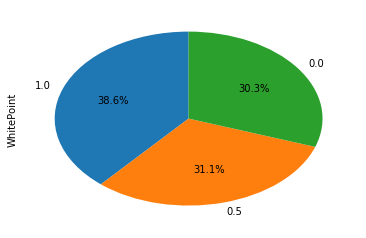

In [18]:
all_matches['WhitePoint'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)

White wins 38.6% to Black's 30.3%. Let's look at the distribution of black and white's elo rating.

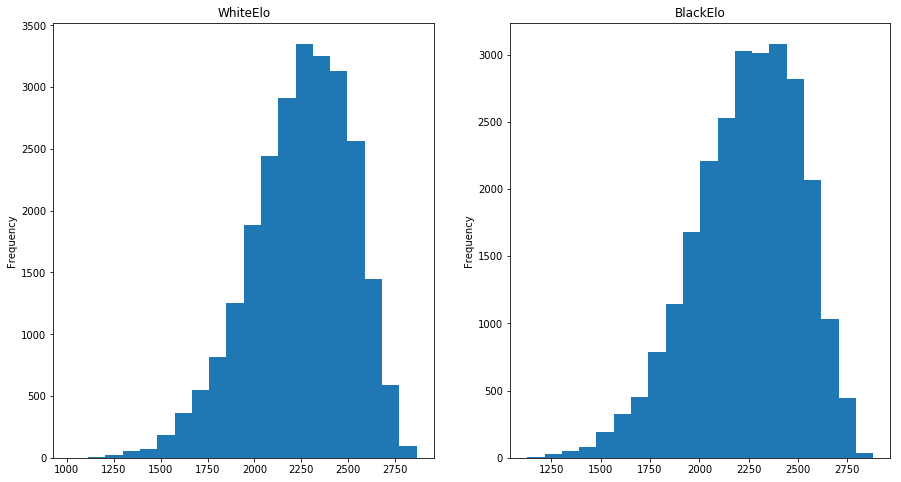

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15,8))
all_matches[all_matches['WhiteElo'].notnull()]['WhiteElo'].plot.hist(ax=axes[0], bins=20, title='WhiteElo')
all_matches[all_matches['BlackElo'].notnull()]['BlackElo'].plot.hist(ax=axes[1], bins=20, title='BlackElo')

The training set is unbalanced toward high levels players (rating over 2000).
This might cause some overfitting later.

Let's change the `"MoveScores"` column from strings to list of strings, and look at the length of the matches.

In [20]:
all_matches['MoveScores'] = all_matches['MoveScores'].apply(lambda x: x.split(' '))

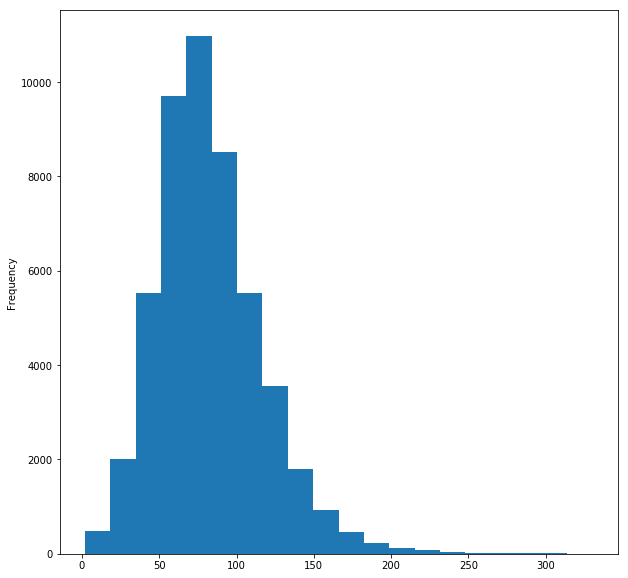

In [21]:
plt.figure(figsize=(10,10))
all_matches['MatchLength'] = all_matches['MoveScores'].apply(len)
all_matches['MatchLength'].plot.hist(bins=20)

In [22]:
all_matches['MatchLength'].describe()

count    50000.000000
mean        82.529460
std         33.977204
min          2.000000
25%         60.000000
50%         79.000000
75%        101.000000
max        330.000000
Name: MatchLength, dtype: float64

Most games last 60-100 moves, with some extreme cases.
There is no way we can predict the rating of a player with just one or 2 moves,
so we can consider too-short games anomalies and handle them accordingly.

@todo: Here I choose to remove them completely from the training set.
You might try a different strategy to handle short games

In [23]:
# All short games (< 8 moves)
short_games = all_matches[np.logical_and(all_matches['MatchLength'] < 8, all_matches['WhiteElo'].notnull())]
len(short_games)

41

In [24]:
# Drop all short games
all_matches.drop(short_games.index, inplace=True)

Now we need to analyze the flow of the game. Here I choose to simply count the good/bad moves each player made.

In [25]:
def analyze_move_scores(
    move_scores,
    *,
    excellent_thres=300,
    good_thres=100,
    mistake_thres=-100,
    blunder_thres=-300,
):
    """
    Count the number of each player's moves in different categories.
    
    The categories are:
    - Excellent: Moves that give major advantage to the player
    - Good: Moves that give minor advantage to the player
    - Mistake: Moves that give minor advantage to the opponent
    - Blunder: Moves that give major advantage to the opponent
    
    We don't need to consider the moves that don't fall in the above categories,
    because it correlates heavily with those.
    
    @todo:
        Currently the threshold values are just some random numbers.
        They can be changed to some better values, or use an adaptive strategy
        to better classify them.
    """
    white = {'excellent': 0, 'good': 0, 'mistake': 0, 'blunder': 0}
    black = {'excellent': 0, 'good': 0, 'mistake': 0, 'blunder': 0}
    last_score = 0
    
    # Coefficient: white = 1, black = -1
    coef = 1
    for i, score_str in enumerate(move_scores):
        current_player = black if i % 2 == 1 else white
        try:
            score = int(score_str)
        except:
            score = last_score
        change = score - last_score
        point = coef * change
        if point >= excellent_thres:
            current_player['excellent'] += 1
        elif point >= good_thres:
            current_player['good'] += 1
        elif point <= blunder_thres:
            current_player['blunder'] += 1
        elif point <= mistake_thres:
            current_player['mistake'] += 1
        coef *= -1
        last_score = score
    
    white_move_count = (len(move_scores) + 1) // 2
    black_move_count = len(move_scores) // 2
    white_ratio = np.array(list(white.values())) / white_move_count
    black_ratio = np.array(list(black.values())) / black_move_count
    return np.concatenate([black_ratio, white_ratio])

In [26]:
(
    all_matches['black_excellent'],
    all_matches['black_good'],
    all_matches['black_mistake'],
    all_matches['black_blunder'],
    all_matches['white_excellent'],
    all_matches['white_good'],
    all_matches['white_mistake'],
    all_matches['white_blunder'],
) = zip(*all_matches['MoveScores'].apply(analyze_move_scores))

all_matches.head()

,BlackElo,WhiteElo,MoveScores,WhitePoint,MatchLength,black_excellent,black_good,black_mistake,black_blunder,white_excellent,white_good,white_mistake,white_blunder
Event,,,,,,,,,,,,,
1,2411.0,2354.0,"[18, 17, 12, 8, -5, 12, 3, -2, 22, 21, 20, 13,...",0.5,38,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000
2,2460.0,2523.0,"[26, 44, 26, 18, 14, 34, 36, 31, 37, 35, 42, 5...",0.5,13,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000
3,1999.0,1915.0,"[26, 51, 68, 57, 65, 77, 48, 93, 61, 63, 63, 5...",0.0,106,0.037736,0.018868,0.018868,0.018868,0.0,0.0,0.018868,0.09434
4,2191.0,2446.0,"[2, 21, 5, 53, 35, 45, 37, 54, 10, 22, 8, 48, ...",1.0,77,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000
5,2075.0,2168.0,"[26, 64, 35, 53, 18, 20, 18, 20, 10, 49, 60, 9...",1.0,49,0.000000,0.000000,0.041667,0.041667,0.0,0.0,0.000000,0.00000


In [27]:
all_matches.describe()

,BlackElo,WhiteElo,WhitePoint,MatchLength,black_excellent,black_good,black_mistake,black_blunder,white_excellent,white_good,white_mistake,white_blunder
count,24959.000000,24959.000000,49959.000000,49959.000000,49959.000000,49959.000000,49959.000000,49959.000000,49959.000000,49959.000000,49959.000000,49959.000000
mean,2242.015385,2246.867383,0.541604,82.594848,0.002979,0.002728,0.037071,0.016892,0.003064,0.003241,0.033840,0.014864
std,271.032216,268.395126,0.412988,33.914334,0.010593,0.009174,0.043118,0.029279,0.010680,0.010218,0.039934,0.026825
min,1128.000000,1021.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2067.000000,2075.000000,0.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2267.000000,2272.000000,0.500000,79.000000,0.000000,0.000000,0.025641,0.000000,0.000000,0.000000,0.023810,0.000000
75%,2447.000000,2447.000000,1.000000,101.000000,0.000000,0.000000,0.058824,0.027027,0.000000,0.000000,0.054054,0.024390
max,2881.000000,2864.000000,1.000000,330.000000,0.166667,0.136364,0.666667,0.666667,0.217391,0.153846,0.363636,0.645161


We have no more use for `"MoveScores"`, so let's delete it

In [28]:
all_matches.drop('MoveScores', axis=1, inplace=True)

# Correlation

In [29]:
# Split into train and test set
train_data = all_matches[all_matches['WhiteElo'].notnull()]
test_data = all_matches[all_matches['WhiteElo'].isnull()]
test_data.drop(columns=['BlackElo', 'WhiteElo'], inplace=True)

/home/nghiatt4/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


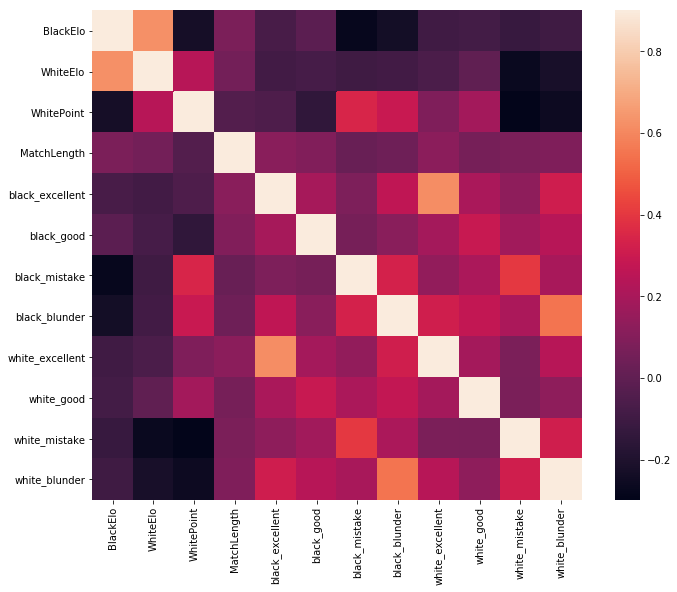

In [30]:
corrmat = train_data.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

`"WhitePoint"` correlates strongly with many other features.
We can remove it, but I choose to leave it for now.

# Building models

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score

In [32]:
def train_and_evaluate(model, x_train, y_train, n_folds=2):
    kf = KFold(n_folds, shuffle=True).get_n_splits(x_train.values)
    score = -cross_val_score(model, x_train.values, y_train.values, scoring='neg_mean_absolute_error', cv=kf)
    return score

In [33]:
x_train = train_data.drop(['BlackElo', 'WhiteElo'], axis=1)
y_train = train_data[['WhiteElo', 'BlackElo']]

In [34]:
linear = LinearRegression(n_jobs=4)
train_and_evaluate(linear, x_train, y_train)

array([ 202.73891278,  199.94904956])

In [35]:
linear.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=4, normalize=False)

In [36]:
predictions = linear.predict(test_data)

In [37]:
submission = np.concatenate([test_data.index.values.reshape((len(predictions), 1)), predictions], axis=1)
submission = pd.DataFrame(submission, columns=['Event', 'WhiteElo', 'BlackElo'])
submission = submission.round().astype(np.int64)

In [38]:
submission.to_csv('submission.csv', index=False)